# Dimensionality Reduction Evaluation Code Appendix

This code is intended to accompany the final project paper for EN.625.609.83.SP22 Matrix Theory.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Enviornment preparation

In [33]:
import pickle
from tqdm.notebook import tqdm

The following packages are introduced so we can manage the Marvel graph data.

In [2]:
import networkx as nx
import pandas as pd

These next packages are imported so we can handle the 20 Newsgroups text data.

In [3]:
import Stemmer
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer

The following packages are used to perform dimensionality reduction.

In [4]:
from sklearn.decomposition import PCA, NMF
from umap import UMAP
import plotly.express as px

The next cells are for tools for evaluating dimensionality reduction.  
For this next cell you'll first need to run
```Bash
pip install git+https://github.com/samueljackson92/coranking.git
```

In [66]:
from coranking.metrics import trustworthiness, continuity

pyDRMetrics is a great library, but very, very slow.

In [5]:
from pyDRMetrics.pyDRMetrics import *

TALE is a standalone tool in Python and Java for reviewing low-dimensional projections. We will pull in some classes and functions from the backend. It is still under construction, and the backend was not intended for this kind of use, so our implementation is a little hacky. All credit for that backend code goes to the TALE team.

In [6]:
from coranking.metrics import trustworthiness, continuity
import six
import sys
sys.modules['sklearn.externals.six'] = six
import talebackend

In [67]:
from importlib import reload

In [132]:
talebackend = reload(talebackend)

## Data preparation

### Marvel Character Network
Before running this next cell, you must download and extract the data from [the Kaggle dataset](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network?resource=download), placing it in the superdirectory `Data`.

In [7]:
hdf = pd.read_csv("../Data/hero-network.csv")

In [8]:
hdf.shape

(574467, 2)

In [9]:
udf = hdf.drop_duplicates()

In [10]:
udf.shape

(224181, 2)

In [11]:
columns = hdf.columns.tolist()
hdf["weights"] = 1
#hdf = hdf.groupby(columns)["weights"].count().reset_index()
tdf = hdf.groupby(columns)["weights"].count()
tdf = tdf.reset_index()

In [12]:
tdf.weights.value_counts()

1      138829
2       39326
3       16532
4        8548
5        5061
        ...  
168         1
351         1
295         1
167         1
184         1
Name: weights, Length: 200, dtype: int64

In [13]:
tdf[tdf.weights>=150]

,hero1,hero2,weights
3090,ANGEL/WARREN KENNETH,BEAST/HENRY &HANK& P,156
3346,ANGEL/WARREN KENNETH,ICEMAN/ROBERT BOBBY,162
4408,ANT-MAN/DR. HENRY J.,CAPTAIN AMERICA,154
4623,ANT-MAN/DR. HENRY J.,IRON MAN/TONY STARK,156
5049,ANT-MAN/DR. HENRY J.,WASP/JANET VAN DYNE,195
...,...,...,...
212460,WASP/JANET VAN DYNE,CAPTAIN AMERICA,193
212669,WASP/JANET VAN DYNE,IRON MAN/TONY STARK,152
214080,"WATSON-PARKER, MARY",SPIDER-MAN/PETER PAR,321
218871,WOLVERINE/LOGAN,COLOSSUS II/PETER RA,159


In [87]:
mini_tdf = tdf[tdf.index<=2000]

In [88]:
G = nx.from_pandas_edgelist(df=mini_tdf, source="hero1", target="hero2", edge_attr="weights")

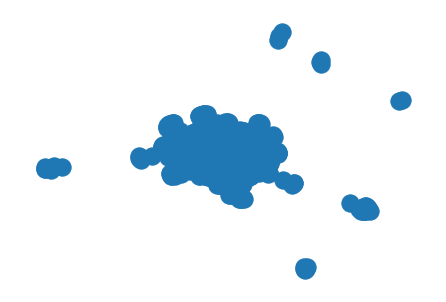

In [89]:
nx.draw_spring(G)

In [90]:
marvel_matrix = nx.adjacency_matrix(G,weight="weights")

<ipython-input-90-278252ef8d39>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  marvel_matrix = nx.adjacency_matrix(G,weight="weights")


In [137]:
n = marvel_matrix.count_nonzero()
x,y = marvel_matrix.shape
dm = n / (x * y)
print("The Marvel matrix has density", dm)

The Marvel matrix has density 0.0029695055199095576


### A bag of words model matrix

In [18]:
# Override TfidfVectorizer
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

In [19]:
dataset = load_dataset("newsgroup",'18828_talk.politics.guns')
text_data = dataset['train']['text']
stemmer = Stemmer.Stemmer('en')
analyzer = CountVectorizer().build_analyzer()
vectorizer = StemmedCountVectorizer(stop_words='english', min_df=5, max_df=0.5)
text_matrix = vectorizer.fit_transform(text_data)  
vocab = vectorizer.get_feature_names_out()

Reusing dataset newsgroups (/home/nick/.cache/huggingface/datasets/newsgroups/18828_talk.politics.guns/3.0.0/8ea0c9dc025ecfbfd96a2c1e22caa1e1281f361946dac08205448d66f78398f5)


  0%|          | 0/1 [00:00<?, ?it/s]

In [145]:
text_matrix.shape

(910, 3631)

In [136]:
n = text_matrix.count_nonzero()
x,y = text_matrix.shape
dt = n / (x * y)
print("The text matrix has density", dt)

The text matrix has density 0.027128723658605233


## Performing dimensionality reduction

In [92]:
low = 2
med = 20
X_t = text_matrix.toarray()
X_m = marvel_matrix.toarray()

In [93]:
pcatlow = PCA(n_components = low) # keep the first low components
pcatlow.fit(X_t)
Z_t_pca_low = pcatlow.transform(X_t)

pcatmed = PCA(n_components = med) # keep the first med components
pcatmed.fit(X_t)
Z_t_pca_med = pcatmed.transform(X_t)

In [94]:
pcamlow = PCA(n_components = low) # keep the first low components
pcamlow.fit(X_m)
Z_m_pca_low = pcamlow.transform(X_m)

pcammed = PCA(n_components = med) # keep the first med components
pcammed.fit(X_m)
Z_m_pca_med = pcammed.transform(X_m)

In [95]:
nmftlow = NMF(n_components = low, init='nndsvda', beta_loss="kullback-leibler", solver="mu", max_iter=(1000)) # keep the first low components
nmftlow.fit(X_t)
Z_t_nmf_low = nmftlow.transform(X_t)

nmftmed = NMF(n_components = med, init='nndsvda', beta_loss="kullback-leibler", solver="mu", max_iter=(1000)) # keep the first med components
nmftmed.fit(X_t)
Z_t_nmf_med = nmftmed.transform(X_t)

In [96]:
nmfmlow = NMF(n_components = low, init='nndsvda', beta_loss="kullback-leibler", solver="mu", max_iter=(1000)) # keep the first low components
nmfmlow.fit(X_m)
Z_m_nmf_low = nmfmlow.transform(X_m)

nmfmmed = NMF(n_components = med, init='nndsvda', beta_loss="kullback-leibler", solver="mu", max_iter=(1000)) # keep the first med components
nmfmmed.fit(X_m)
Z_m_nmf_med = nmfmmed.transform(X_m)

In [97]:
umaptlow = UMAP(n_components = low, init='random')
umaptlow.fit(X_t)
Z_t_umap_low = umaptlow.transform(X_t)

umaptmed = UMAP(n_components = med, init='random')
umaptmed.fit(X_t)
Z_t_umap_med = umaptmed.transform(X_t)

In [98]:
umapmlow = UMAP(n_components = low, init='random')
umapmlow.fit(X_m)
Z_m_umap_low = umapmlow.transform(X_m)

umapmmed = UMAP(n_components = med, init='random')
umapmmed.fit(X_m)
Z_m_umap_med = umapmmed.transform(X_m)

This next cell just backs up our work so far.

In [99]:
mats = [X_t, X_m]
lows = [Z_t_pca_low,Z_m_pca_low,Z_t_nmf_low,Z_m_nmf_low,Z_t_umap_low,Z_m_umap_low]
meds = [Z_t_pca_med,Z_m_pca_med,Z_t_nmf_med,Z_m_nmf_med,Z_t_umap_med,Z_m_umap_med]
with open("../Data/matrices.pkl", 'wb') as pfile:
    pickle.dump([mats, lows, meds], pfile)

## Evaluate reductions

Kruskal stress

In [122]:
lows_ks = []
for i in tqdm(range(len(lows))):
    s = talebackend.Stress(mats[i%2],lows[i])
    kruskal_stress = s.compute()
    lows_ks.append(kruskal_stress)

  0%|          | 0/6 [00:00<?, ?it/s]

In [124]:
meds_ks = []
for i in tqdm(range(len(meds))):
    s = talebackend.Stress(mats[i%2],meds[i])
    kruskal_stress = s.compute()
    meds_ks.append(kruskal_stress)

  0%|          | 0/6 [00:00<?, ?it/s]

Coranking-based measures

In [134]:
lows_ms = []
lows_bc = []
lows_qc = []
for i in tqdm(range(len(lows))):
    c = talebackend.CorankingMatrix(high_dimensional_data=mats[i%2],
                            low_dimensional_data=lows[i],
                            distance_metric='euclidean',)
    b = talebackend.CorankingMatrixBehaviourCriterion(high_dimensional_data=mats[i%2],
                                                     low_dimensional_data=lows[i],
                                                     distance_metric='euclidean',
                                                     coranking_matrix=c,
                                                     )
    q = talebackend.CorankingMatrixQualityCriterion(high_dimensional_data=mats[i%2],
                                                     low_dimensional_data=lows[i],
                                                     distance_metric='euclidean',
                                                     coranking_matrix=c,
                                                     )    
    m = talebackend.MRRE(high_dimensional_data=mats[i%2],
                     low_dimensional_data=lows[i],
                     distance_metric='euclidean',
                     coranking_matrix=c,
                     )
    bc = b.compute()
    ms = m.compute()
    qc = q.compute()
    lows_ms.append(ms)
    lows_bc.append(bc)
    lows_qc.append(qc)

  0%|          | 0/6 [00:00<?, ?it/s]

In [135]:
meds_ms = []
meds_bc = []
meds_qc = []
for i in tqdm(range(len(meds))):
    c = talebackend.CorankingMatrix(high_dimensional_data=mats[i%2],
                            low_dimensional_data=meds[i],
                            distance_metric='euclidean',)
    b = talebackend.CorankingMatrixBehaviourCriterion(high_dimensional_data=mats[i%2],
                                                     low_dimensional_data=meds[i],
                                                     distance_metric='euclidean',
                                                     coranking_matrix=c,
                                                     )
    q = talebackend.CorankingMatrixQualityCriterion(high_dimensional_data=mats[i%2],
                                                     low_dimensional_data=lows[i],
                                                     distance_metric='euclidean',
                                                     coranking_matrix=c,
                                                     )      
    m = talebackend.MRRE(high_dimensional_data=mats[i%2],
                     low_dimensional_data=meds[i],
                     distance_metric='euclidean',
                     coranking_matrix=c,
                     )
    bc = b.compute()
    ms = m.compute()
    qc = q.compute()
    meds_ms.append(ms)
    meds_bc.append(bc)
    meds_qc.append(qc)

  0%|          | 0/6 [00:00<?, ?it/s]

In [143]:
types = ["text", "graph"]
dims = [X_t.shape[1], X_m.shape[1]]
densities = [dt, dm]
metrics = pd.DataFrame()
metrics["Data"] = types * len(lows)
metrics["DR"] = ["PCA","PCA","NMF","NMF","UMAP","UMAP"]*2
metrics["High"] = dims * len(lows)
metrics["Low"] = [low] * len(lows) + [med]*len(meds)
metrics["Density"] = densities * len(lows) 
metrics["Kruskal Stress"] =  lows_ks + meds_ks
metrics["MRRE"] =  lows_ms + meds_ms
metrics["Coranking Quality"] = lows_qc + meds_qc
metrics["Coranking Behavior"] = lows_bc + meds_bc

In [144]:
metrics

,Data,DR,High,Low,Density,Kruskal Stress,MRRE,Coranking Quality,Coranking Behavior
0,text,PCA,3631,2,0.027129,0.163828,0,0.014101,0.000577
1,graph,PCA,1158,2,0.002970,0.411585,0,0.161024,0.000387
2,text,NMF,3631,2,0.027129,0.244743,0,0.004747,0.000410
3,graph,NMF,1158,2,0.002970,0.438609,0,0.070470,0.001897
4,text,UMAP,3631,2,0.027129,0.455812,0,0.188047,0.006777
5,graph,UMAP,1158,2,0.002970,0.519252,0,0.181188,0.001310
6,text,PCA,3631,20,0.027129,0.103706,0,0.215109,0.002669
7,graph,PCA,1158,20,0.002970,0.210524,0,0.252444,0.001467
8,text,NMF,3631,20,0.027129,0.137815,0,0.109935,0.005748
9,graph,NMF,1158,20,0.002970,0.393748,0,0.166651,0.006948


In [146]:
metrics[metrics["Data"]=="text"]

,Data,DR,High,Low,Density,Kruskal Stress,MRRE,Coranking Quality,Coranking Behavior
0,text,PCA,3631,2,0.027129,0.163828,0,0.014101,0.000577
2,text,NMF,3631,2,0.027129,0.244743,0,0.004747,0.000410
4,text,UMAP,3631,2,0.027129,0.455812,0,0.188047,0.006777
6,text,PCA,3631,20,0.027129,0.103706,0,0.215109,0.002669
8,text,NMF,3631,20,0.027129,0.137815,0,0.109935,0.005748
10,text,UMAP,3631,20,0.027129,0.367856,0,0.364463,0.005375


In [147]:
metrics[metrics["Data"]=="graph"]

,Data,DR,High,Low,Density,Kruskal Stress,MRRE,Coranking Quality,Coranking Behavior
1,graph,PCA,1158,2,0.00297,0.411585,0,0.161024,0.000387
3,graph,NMF,1158,2,0.00297,0.438609,0,0.070470,0.001897
5,graph,UMAP,1158,2,0.00297,0.519252,0,0.181188,0.001310
7,graph,PCA,1158,20,0.00297,0.210524,0,0.252444,0.001467
9,graph,NMF,1158,20,0.00297,0.393748,0,0.166651,0.006948
11,graph,UMAP,1158,20,0.00297,0.454118,0,0.191261,0.000398


## Overfitting figure

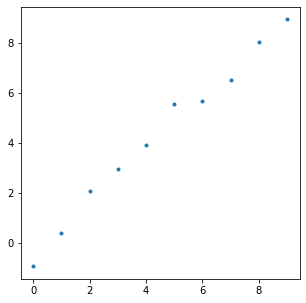

In [47]:
figure(figsize=(5,5))
d = 10
x = list(range(10))
y = x
eps = np.random.normal(0,0.5,d)
yeps = y + eps
plot(x,yeps,'.');

In [51]:
m1 = polyfit(x, yeps, 1)
p1 = poly1d(m1)
m5 = polyfit(x, yeps, 4)
p5 = poly1d(m5)

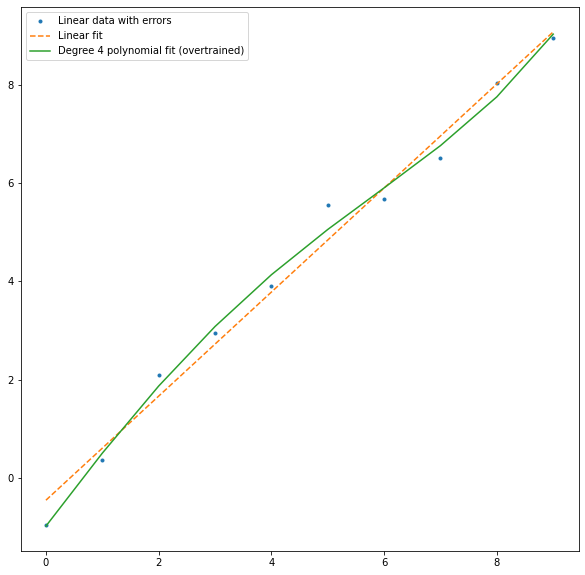

In [58]:
f = figure(figsize=(10,10))
plot(x,yeps,'.', label="Linear data with errors");
plot(x, p1(x), '--', label="Linear fit")
plot(x, p5(x), label="Degree 4 polynomial fit (overtrained)")
legend();
f.savefig("../Images/overfitting.jpg",)

In [150]:
717/735

0.9755102040816327